# Recommendations with IBM

In this notebook, I am analysing users' interactions with articles on the IBM Watson Studio platform and making recommendations to them about new articles that I think they might like. Below is an example of what a dashboard displaying articles on the IBM Watson platform might look like.

![IBM_Watson_Platform](data/screen-shot-2018-09-17-at-3.40.30-pm.png)

While the dashboard displays only the most recent articles, envision a recommendation board tailored to each user, showcasing the most relevant articles. To achieve this, I conducted a data analysis using the IBM Watson Studio platform to determine the articles most pertinent to individual users. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorisation](#Matrix-Fact)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>
`1.` I will use the dictionary and the cells below to provide insights into the descriptive statistics of the data. Specifically, I will analyse the distribution of how many articles each user interacts with in the dataset. I will include both visualisations and descriptive statistics to illustrate the frequency of user interactions with articles.

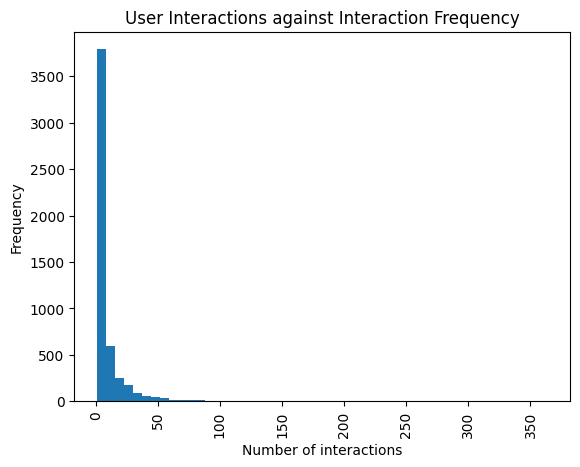

In [3]:
df_hist = df.groupby(by='email').count().iloc[:, 0]

fig, ax = plt.subplots()

ax.hist(df_hist, bins=50)
ax.set_title('User Interactions against Interaction Frequency')
ax.set_xlabel('Number of interactions')
ax.tick_params(axis='x', rotation=90)

ax.set_ylabel('Frequency')
plt.show()

In [10]:
# 50% of individuals interact with ____ number of articles or fewer.
median_val = np.median(df_hist)
# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = max(df_hist)

print(f'50% of people interact with {median_val} number of articles or less.')
print (f'The maximum number of user-article interactions by any 1 user is {max_views_by_user}.')

50% of people interact with 3.0 number of articles or less.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Here I explore and remove duplicate articles from the **df_content** DataFrame.  

In [4]:
# Find and explore duplicate articles
df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [5]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id')

`3.` The cells below I use to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [6]:
unique_articles = len(df['article_id'].unique())  # The number of unique articles that have at least one interaction
total_articles = len(np.unique(df_content['article_id']))  # The number of unique articles on the IBM platform
unique_users = df['email'].nunique()  # The number of unique users
user_article_interactions = df.shape[0]  # The number of user-article interactions

`4.` The cells below show the most viewed **article_id** and the number of times it was viewed. After talking to the company managers, the `email_mapper` function was deemed a reasonable way to map users to ids. There were a small number of null values, and it was found that all of these null values probably belonged to a single user (which is how they are stored using the function below).

In [8]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df.groupby('article_id').count().iloc[:, 0].idxmax())
# The most viewed article in the dataset was viewed how many times?
max_views = max(df.groupby('article_id').count().iloc[:, 0])

In [8]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [11]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

NameError: name 'max_views' is not defined

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We do not have ratings indicating whether a user liked an article. We only know that a user has interacted with an article. Therefore, the popularity of an article can only be determined by the frequency of interactions it receives.

`1.` I will fill in the function below to return the **n** top articles, ordered by the number of interactions, with the most-interacted articles at the top. I will then test my function using the tests provided.

In [12]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_article_titles = df.groupby('title').count()['user_id'].sort_values(ascending=False).iloc[:n].index
    
    return list(top_article_titles)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_article_ids =  df.groupby('article_id').count()['user_id'].sort_values(ascending=False).iloc[:n].index
    top_article_ids = list(map(str, top_article_ids))
    return top_article_ids

In [13]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [15]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` I use the function below to reformat the **df** dataframe so that users are displayed as rows and articles as columns.

- Each **user** will only appear once in each **row**.
- Each **article** will only appear once in each **column**.
- When a user has interacted with an article, I place a 1 where the user row intersects the article column. Regardless of how many times a user has interacted with the article, all such entries will be marked as 1.
- If a user has not interacted with an article, I will place a 0 where the user row intersects the article column.

I use the tests provided to ensure that the basic structure of the matrix matches the expected solution.

In [16]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    user_ids = np.unique(df['user_id'])
    article_ids = np.unique(df['article_id'])

    # Create a pivot table
    user_item = df.pivot_table(index='user_id',
                               columns='article_id',
                               aggfunc=lambda x: 1,
                               fill_value=0)

    user_item.columns = article_ids
    user_item.columns.name = 'article_id'
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [17]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` I complete the function below to take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar). The returned result does not contain the provided user_id, as we know that each user is similar to themselves. Since the results for each user here are binary, it makes sense to compute similarity as the dot product of two users.

I use the tests to verify my function.

In [18]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of each pair of users based on the dot product
    Returns an ordered list
    
    '''
    # compute similarity of each user to the provided user
    sim_series = pd.Series(np.dot(user_item, user_item.loc[user_id]),
                                  index=user_item.index)
    
    # sort by similarity
    sim_series = sim_series.sort_values(ascending=False)
    
    # create list of just the ids
    sim_list = list(sim_series.index)
    
    # remove the own user's id
    sim_list.remove(user_id)
       
    return sim_list

In [19]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that I have a function that provides the most similar users to each user, I use these users to find articles I can recommend. I complete the functions below to return the articles I would recommend to each user.

In [20]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - article id as integer or iterable
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''   
    if isinstance(article_ids, int):
        article_names = list(df.loc[df['article_id']==article_ids, 'title'].unique())
        
    else:
        article_names = list()
        
        for article_id in article_ids:
            new_title = df.loc[df['article_id'].astype(str) == str(article_id), 'title'].unique()
            article_names.extend(new_title)
        
    return article_names


def get_user_articles(user_id, user_item=user_item):
    '''
    Get a list of article IDs and associated names seen by a user.

    Parameters:
    - user_id (int or iterable): User ID or a collection of user IDs.
    - user_item (pandas dataframe): Matrix of users by articles (1's when a user has interacted with an article, 0 otherwise).

    Returns:
    - article_ids (list): A list of article IDs seen by the user(s).
    - article_names (list): A list of article names associated with the list of article IDs.

    Description:
    - For a given user ID or a collection of user IDs, returns the list of article IDs and their associated names that have been seen by the user(s).
    '''

    # Check if user_id is an integer (single user) or an iterable (multiple users)
    if isinstance(user_id, int):
        # Extract article IDs for a single user
        article_ids = list(map(str, user_item.loc[user_id, user_item.loc[user_id] > 0].index))
    else:
        # Extract article IDs for multiple users
        article_ids = user_item.loc[user_id, user_item.loc[user_id].sum() > 0].columns.values
        article_ids = list(map(str, article_ids))
    
    # Get article names corresponding to the article IDs
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names



def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''

    similar_users = find_similar_users(user_id)
    article_ids = get_user_articles(user_id)[0]
    
    recs = list()
    
    for similar_user in similar_users:
        new_ids = get_user_articles(similar_user)[0]
        ids_not_read = np.setdiff1d(new_ids, article_ids)

        # Ensure the loop breaks when m recommendations are reached
        for new_id in ids_not_read[:m - len(recs)]:
            if new_id not in recs and len(recs) < m:
                recs.append(new_id)
            
        # Break the outer loop if m recommendations are reached
        if len(recs) >= m:
            break

    return recs

In [21]:
# check results, return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10)) 

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [22]:
get_article_names(['1320.0', '232.0', '844.0'])

['housing (2015): united states demographic measures',
 'self-service data preparation with ibm data refinery',
 'use the cloudant-spark connector in python notebook']

In [23]:
# Test functions
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now, I improve the consistency of the **user_user_recs** function from above.

- Instead of arbitrarily selecting users who have the same closeness to a given user, I choose the users with the most total article interactions first, before considering those with fewer interactions.

- Instead of arbitrarily selecting articles where the number of recommended articles starts below **m** and ends exceeding **m**, I choose articles based on the total number of interactions. This ranking should align with what is obtained from the **top_articles** function I wrote earlier.

In [24]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int) the user ID for whom we want to find similar users
    df - (pandas dataframe) the main dataframe containing user-article interactions
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - user_id of similar users
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by each user
                    
    Other Details:
    - Sorts the neighbors_df by similarity and then by the number of interactions, 
      with the highest of each at the top of the dataframe.
    '''
    # Calculate similarity between the given user and all other users
    similarity = np.dot(user_item, user_item.loc[user_id])
    
    # Count the number of article interactions for each user
    num_interactions = df.groupby('user_id').count()['article_id'].values
    
    # Get the user IDs as index
    neighbor_id = user_item.index

    # Create a dataframe with similarity and num_interactions
    neighbors_df = pd.DataFrame(data={'similarity': similarity,
                                      'num_interactions': num_interactions},
                                index=neighbor_id)
    
    # Set the index name
    neighbors_df.index.name = 'neighbor_id'
    
    # Drop the current user from the dataframe
    neighbors_df.drop(user_id, inplace=True)
    
    # Sort the dataframe by similarity and the number of interactions
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id for whom we want to make article recommendations
    m - (int) the number of recommendations to generate for the user
    
    OUTPUT:
    recs - (list) a list of article recommendations for the user by article id
    rec_names - (list) a list of article recommendations for the user by article title
    
    Description:
    - Loops through users based on closeness to the input user_id
    - For each user, finds articles the user hasn't seen before and provides them as recommendations
    - Continues this process until m recommendations are found
    
    Notes:
    * Chooses users with the most total article interactions first before those with fewer interactions.
    * Chooses articles with the most total interactions before those with fewer total interactions.
    '''
    # Get and similar users sorted by their interaction
    similar_users = get_top_sorted_users(user_id).index
    
    # Get the articles already seen by the given user
    user_article_ids = get_user_articles(user_id)[0]
    
    # Get all user interactions with articles
    article_interactions = df.groupby('article_id').count()['user_id']
    
    # Initialize recommendation lists
    recs = list()    
    
    for similar_user in similar_users:
        
        # Get articles of similar user and make sure they were not yet read
        new_ids = get_user_articles(similar_user)[0]        
        new_ids = np.setdiff1d(new_ids, user_article_ids)
        new_ids = map(float, new_ids)
        
        # Sort new_ids by article interactions
        new_ids_ordered = article_interactions.loc[new_ids].sort_values(ascending=False).index
        
        for article_id in new_ids_ordered:
            if len(recs) < m and article_id not in recs:
                recs.append(article_id)
                
        if len(recs) == m: break
            
    # Get article names from recommended article IDs
    rec_names = get_article_names(recs)
    
    return recs, rec_names


In [25]:
# quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` I use my functions from above to correctly fill in the solutions to the dictionary below. Then, I test my dictionary against the solution. I provide the code needed to answer each of the following comments.

In [26]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).index[0]
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).index[9]

In [27]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, I would use the `get_top_article_ids` function to make recommendations. This method is suitable because the new user has not viewed any articles previously, and we have no additional information about their preferences. By recommending the top articles based on overall popularity, I can provide relevant suggestions despite the lack of user-specific interaction data.

`7.` Using my existing functions, I provide the top 10 recommended articles for a new user below. I test my function against our expectations to ensure we are aligned on how to make recommendations.

In [28]:
new_user = '0.0'

# What are recommendations for this new user '0.0'?  As a new user, they have no observed articles.
new_user_recs = get_top_article_ids(10)

In [29]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorisation</a>

In this part of the notebook, I use matrix factorisation to make article recommendations to the users on the IBM Watson Studio platform.

`1.` I have already created a **user_item** matrix in **question 1** of **Part III** above. For this first question, I only need to run the cells to set up everything for the rest of **Part V** of the notebook.

In [30]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [31]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, I use Singular Value Decomposition (SVD) from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix. I perform SVD because the missing data has been converted to 0s, which makes it possible to run the SVD.

In [32]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

`3.` Determining the optimal number of latent features can be challenging. By running the cell below, it becomes evident that increasing the number of latent features reduces the error rate in predictions for the 1 and 0 values in the user-item matrix. This cell provides insight into how accuracy improves with a higher number of latent features.

/Users/romanwolf/Code/Recommendations with IBM/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


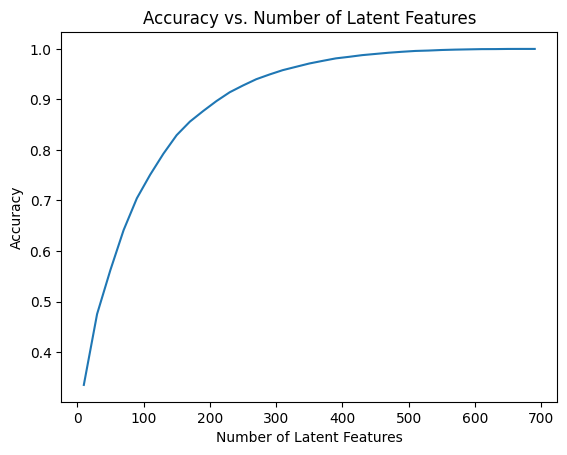

In [33]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` The optimal number of latent features is not easily determined solely by how well predictions match the 1s and 0s in the matrix, as this does not necessarily indicate the quality of recommendations. To better assess recommendation performance, the dataset should be split into training and test sets, as demonstrated in the cell below.

Using the code from question 3, I evaluate the impact on accuracy with different numbers of latent features for both the training and test sets. Specifically:

- Determine how many users can receive predictions in the test set.
- Identify how many users cannot receive predictions due to the cold start problem.
- Count how many articles can be predicted in the test set.
- Identify how many articles cannot be predicted due to the cold start problem.

In [34]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [35]:
# how many users can receive predictions in the test set?
len(np.intersect1d(df_train['user_id'], df_test['user_id']))

20

In [36]:
# how many users cannot receive predictions due to the cold start problem?
unique_test_users_count = len(set(df_test['user_id']))
common_users_count = len(set(df_train['user_id']).intersection(df_test['user_id']))

unique_test_users_count - common_users_count

662

In [37]:
# how many articles can be predicted in the test set?
len(set(df_train['article_id']).intersection(df_test['article_id']))

574

In [38]:
# how many articles cannot be predicted due to the cold start problem?
len(df_test['article_id'].unique()) - len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))

0

In [49]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
    }

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` I use the **user_item_train** dataset to perform Singular Value Decomposition (SVD), which decomposes it into three matrices: **U**, **S**, and **V^T**. Here, **U** represents the user-feature matrix, **S** is the diagonal matrix of singular values, and **V^T** is the transpose of the item-feature matrix. 

Next, I apply this matrix decomposition to the **user_item_test** dataset to identify which rows can be predicted. I test different numbers of latent features to determine the optimal number based on accuracy. This involves integrating the steps from questions 2 through 4.

I use the cells below to evaluate how effectively SVD predicts recommendations for the test data.

In [50]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [53]:
# Extract relevant information from the training data
train_idx = np.array(user_item_train.index)
train_articles = np.array(user_item_train.columns)

# Identify overlapping users and articles between the test and training sets
test_users = np.intersect1d(test_idx, train_idx)
test_articles = np.intersect1d(test_arts, train_articles)

# Obtain the indices of the overlapping users and articles in the training set
test_users_idx = np.where(np.isin(train_idx, test_users))[0]
test_articles_idx = np.where(np.isin(train_articles, test_articles))[0]

# Filter the test set based on the identified users
test_indexes = np.where(np.isin(test_idx, test_users))[0]
user_item_test = user_item_test.iloc[test_indexes, :]

# Define a range of latent features to evaluate
num_latent_feats = np.arange(10, 700 + 10, 20)
sum_errs = []

# Iterate over different numbers of latent features
for k in num_latent_feats:
    # Reshape matrices with the specified number of latent features (k)
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

    # Extract latent feature matrices for the test set
    u_test, vt_test = u_new[test_users_idx, :], vt_new[:, test_articles_idx]

    # Predict user-item interactions using the dot product of matrices
    user_item_test_est = np.around(np.dot(np.dot(u_test, s_new), vt_test))

    # Compute the absolute error for each prediction compared to the actual value
    diffs = np.subtract(user_item_test, user_item_test_est)

    # Calculate the total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs), axis=0), axis=0)
    sum_errs.append(err)

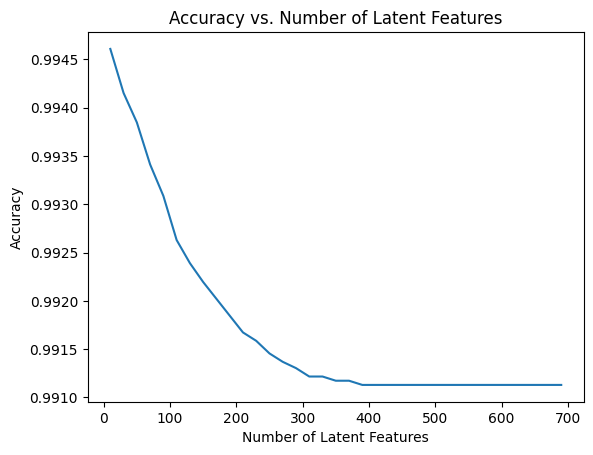

In [54]:
# plot
fig, ax = plt.subplots()
ax.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])

ax.set_xlabel('Number of Latent Features')
ax.set_ylabel('Accuracy')

ax.set_title('Accuracy vs. Number of Latent Features')

plt.show()

`6.` I use the cell below to comment on the results from the previous question. Given these results, I discuss how to determine if the recommendations provided by any of the recommendation systems represent an improvement over how users currently find articles.

In contrast to the previous example, accuracy decreases as the number of latent features increases. However, within an approximate range of 1% below perfect accuracy. As mentioned above, there are only 20 users in the training and test data, which could explain this. Also, only about one percent of the data in the training data frame are 1s, i.e. there is a strong class imbalance. This means that the model may be biased towards the majority class, leading to poor predictions for the minority class. In such cases, the model may have high accuracy on the majority class, but poor performance on the minority class.

To overcome the above problems, it would be useful to:
* Use data augmentation techniques such as over- and under-sampling or synthetic data generation to reduce the binary class imbalance and improve the model.
* Improve the train-test splitting, e.g. use scikit-learn's train_test_split and randomly select rows for either the training or test set and make sure that the ratio of 1s to 0s is the same in the training and test sets, i.e. set stratify to "True". Also increase the test set to about 20% of the available data. 

To determine if the recommendations are an improvement over the current way users find articles, there are several options:
* Test the new recommendation system against the current system (A/B testing). Use statistical significance tests to determine whether the differences between the two recommendation systems are significant.
* Collect feedback from users to understand their subjective preferences with the recommendation systems.
* Use cross-validation to simulate how well the recommendation system performs on unseen data.